In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-03 23:47:32.936240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 23:47:32.950945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 23:47:32.951427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-03 23:47:33.234102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 23:47:33.234850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 23:47:33.235223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-03 23:47:33.235530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 2.31015372e+00, 2.94472432e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [2.26090264e+00, 2.75818849e+00, 0.00000000e+00],
         ...,
         [1.36029601e+00, 1.10707366e+00, 1.21319771e+00],
         [4.03116792e-01, 0.00000000e+00, 3.47944808e+00],
         [0.00000000e+00, 7.04401791e-01, 0.00000000e+00]],

        [[6.20321214e-01, 2.18508050e-01, 1.52083528e+00],
         [0.00000000e+00, 4.53018284e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [8.99101138e-01, 0.00000000e+00, 0.00000000e+00],
         [9.85801339e-01, 0.00000000e+00, 4.83585167e+00],
         [4.35354784e-02, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 9.51999128e-01],
         [8.03152919e-01, 1.46381959e-01, 0.00000000e+00],
         ...,
         [1

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.00000000e+00, 2.31015372e+00, 2.94472432e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [2.26090264e+00, 2.75818849e+00, 0.00000000e+00],
          ...,
          [1.36029601e+00, 1.10707366e+00, 1.21319771e+00],
          [4.03116792e-01, 0.00000000e+00, 3.47944808e+00],
          [0.00000000e+00, 7.04401791e-01, 0.00000000e+00]],
 
         [[6.20321214e-01, 2.18508050e-01, 1.52083528e+00],
          [0.00000000e+00, 4.53018284e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [8.99101138e-01, 0.00000000e+00, 0.00000000e+00],
          [9.85801339e-01, 0.00000000e+00, 4.83585167e+00],
          [4.35354784e-02, 0.00000000e+00, 0.00000000e+00]],
 
         [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 0.00000000e+00, 9.51999128e-01],
          [8.03152919e-01, 1.46381959e-01, 0.00000000e+0

<IPython.core.display.Javascript object>


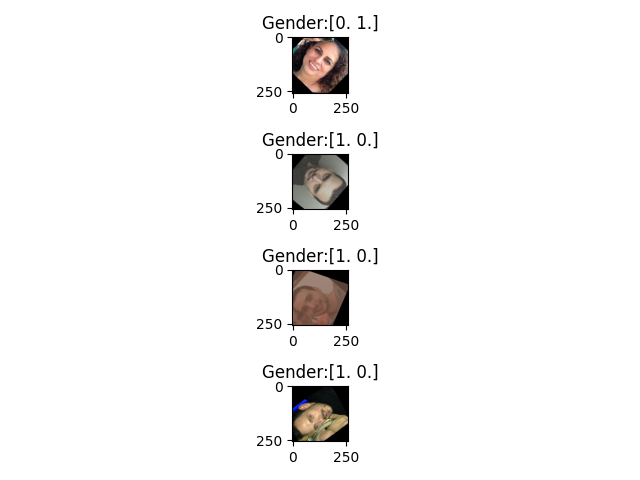

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [36]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(128, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_11')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 64

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 64)           1001856     ['tf.math.subtract[0][0]']   

### Compile Model

In [37]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [38]:
def schedule(epoch, lr):
    return lr

In [39]:
logBasePath = "log/AE_11"
logPrefix = "log"

In [47]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-03 23:48:03.829092: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-03 23:48:03.829109: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-03 23:48:03.829127: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-03 23:48:04.231043: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-03 23:48:04.232388: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed


3528/3528 [==============================] - 14s 4ms/step - loss: 7722.6270 - gender_out_loss: 0.6928 - tf.math.multiply_1_loss: 5990.6270 - gender_out_accuracy: 0.5238
Epoch 1/300
   1/1000 [..............................] - ETA: 12:48 - loss: 8229.5352 - gender_out_loss: 0.7003 - tf.math.multiply_1_loss: 6478.7578 - gender_out_accuracy: 0.2500

2022-11-03 23:48:18.808590: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-03 23:48:18.808656: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   8/1000 [..............................] - ETA: 1:01 - loss: 9510.4932 - gender_out_loss: 0.6911 - tf.math.multiply_1_loss: 7782.6338 - gender_out_accuracy: 0.5000

2022-11-03 23:48:19.256474: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-03 23:48:19.257579: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-03 23:48:19.295687: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3224 callback api events and 3183 activity events. 
2022-11-03 23:48:19.327577: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-03 23:48:19.375120: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19

2022-11-03 23:48:19.438832: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19/rachanon-pc1.trace.json.gz


  30/1000 [..............................] - ETA: 28s - loss: 9181.0498 - gender_out_loss: 0.7024 - tf.math.multiply_1_loss: 7425.0415 - gender_out_accuracy: 0.5917

2022-11-03 23:48:19.485798: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19

2022-11-03 23:48:19.491523: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19/rachanon-pc1.memory_profile.json.gz
2022-11-03 23:48:19.492543: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19
Dumped tool data for xplane.pb to log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19/rachanon-pc1.xplane.pb
Dumped tool data for overview_page.pb to log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19/rachanon-pc1.overview_page.pb
Dumped tool data for input_pipeline.pb to log/AE_11/log_0/plugins/profile/2022_11_03_23_48_19/rachanon-pc1.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to log/AE_11/log_0/plugins/profile/2022_11_03_23_4

1000/1000 [==============================] - 22s 22ms/step - loss: 4627.9346 - gender_out_loss: 0.6793 - tf.math.multiply_1_loss: 2929.6211 - gender_out_accuracy: 0.5735 - val_loss: 3872.0486 - val_gender_out_loss: 0.6799 - val_tf.math.multiply_1_loss: 2172.3623 - val_gender_out_accuracy: 0.5766
Epoch 2/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3275.3347 - gender_out_loss: 0.6567 - tf.math.multiply_1_loss: 1633.6198 - gender_out_accuracy: 0.6210 - val_loss: 3414.9653 - val_gender_out_loss: 0.6801 - val_tf.math.multiply_1_loss: 1714.7233 - val_gender_out_accuracy: 0.5747
Epoch 3/300
1000/1000 [==============================] - 21s 21ms/step - loss: 3005.8542 - gender_out_loss: 0.6510 - tf.math.multiply_1_loss: 1378.4133 - gender_out_accuracy: 0.5928 - val_loss: 3250.8701 - val_gender_out_loss: 0.6839 - val_tf.math.multiply_1_loss: 1541.0397 - val_gender_out_accuracy: 0.5834
Epoch 4/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2962.2

1000/1000 [==============================] - 21s 21ms/step - loss: 2415.3416 - gender_out_loss: 0.6343 - tf.math.multiply_1_loss: 829.4977 - gender_out_accuracy: 0.6263 - val_loss: 2661.3311 - val_gender_out_loss: 0.6694 - val_tf.math.multiply_1_loss: 987.8378 - val_gender_out_accuracy: 0.6099
Epoch 54/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2329.3911 - gender_out_loss: 0.6196 - tf.math.multiply_1_loss: 780.4759 - gender_out_accuracy: 0.6582 - val_loss: 2585.4243 - val_gender_out_loss: 0.6302 - val_tf.math.multiply_1_loss: 1009.8392 - val_gender_out_accuracy: 0.6474
Epoch 55/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2353.9419 - gender_out_loss: 0.6157 - tf.math.multiply_1_loss: 814.6297 - gender_out_accuracy: 0.6605 - val_loss: 2581.9382 - val_gender_out_loss: 0.6382 - val_tf.math.multiply_1_loss: 986.3629 - val_gender_out_accuracy: 0.6366
Epoch 56/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2320.641

Epoch 80/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2180.5034 - gender_out_loss: 0.5674 - tf.math.multiply_1_loss: 761.9756 - gender_out_accuracy: 0.7020 - val_loss: 2565.8643 - val_gender_out_loss: 0.6306 - val_tf.math.multiply_1_loss: 989.2477 - val_gender_out_accuracy: 0.6563
Epoch 81/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2318.3325 - gender_out_loss: 0.6069 - tf.math.multiply_1_loss: 800.9957 - gender_out_accuracy: 0.6727 - val_loss: 2462.3743 - val_gender_out_loss: 0.5978 - val_tf.math.multiply_1_loss: 967.8081 - val_gender_out_accuracy: 0.6741
Epoch 82/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2316.1680 - gender_out_loss: 0.6092 - tf.math.multiply_1_loss: 793.2283 - gender_out_accuracy: 0.6693 - val_loss: 2482.6443 - val_gender_out_loss: 0.6071 - val_tf.math.multiply_1_loss: 964.9448 - val_gender_out_accuracy: 0.6596
Epoch 83/300
1000/1000 [==============================] - 21s 21ms/step - lo

Epoch 107/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2138.8660 - gender_out_loss: 0.5524 - tf.math.multiply_1_loss: 757.8769 - gender_out_accuracy: 0.7245 - val_loss: 2478.0627 - val_gender_out_loss: 0.6061 - val_tf.math.multiply_1_loss: 962.9138 - val_gender_out_accuracy: 0.6797
Epoch 108/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2216.2126 - gender_out_loss: 0.5754 - tf.math.multiply_1_loss: 777.7227 - gender_out_accuracy: 0.6970 - val_loss: 2439.7385 - val_gender_out_loss: 0.5907 - val_tf.math.multiply_1_loss: 963.0032 - val_gender_out_accuracy: 0.6819
Epoch 109/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2222.5269 - gender_out_loss: 0.5690 - tf.math.multiply_1_loss: 800.0987 - gender_out_accuracy: 0.6975 - val_loss: 2427.9976 - val_gender_out_loss: 0.5871 - val_tf.math.multiply_1_loss: 960.3328 - val_gender_out_accuracy: 0.6936
Epoch 110/300
1000/1000 [==============================] - 21s 21ms/step 

1000/1000 [==============================] - 21s 21ms/step - loss: 2101.8406 - gender_out_loss: 0.5365 - tf.math.multiply_1_loss: 760.5963 - gender_out_accuracy: 0.7358 - val_loss: 2372.2581 - val_gender_out_loss: 0.5642 - val_tf.math.multiply_1_loss: 961.8522 - val_gender_out_accuracy: 0.7216
Epoch 160/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1996.9928 - gender_out_loss: 0.4983 - tf.math.multiply_1_loss: 751.2755 - gender_out_accuracy: 0.7548 - val_loss: 2714.8669 - val_gender_out_loss: 0.7052 - val_tf.math.multiply_1_loss: 951.9598 - val_gender_out_accuracy: 0.6700
Epoch 161/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2073.8040 - gender_out_loss: 0.5317 - tf.math.multiply_1_loss: 744.6746 - gender_out_accuracy: 0.7310 - val_loss: 2926.7500 - val_gender_out_loss: 0.7913 - val_tf.math.multiply_1_loss: 948.3956 - val_gender_out_accuracy: 0.6051
Epoch 162/300
1000/1000 [==============================] - 21s 21ms/step - loss: 2124.3

1000/1000 [==============================] - 21s 21ms/step - loss: 1949.8446 - gender_out_loss: 0.4789 - tf.math.multiply_1_loss: 752.6052 - gender_out_accuracy: 0.7610 - val_loss: 2271.5278 - val_gender_out_loss: 0.5325 - val_tf.math.multiply_1_loss: 940.2715 - val_gender_out_accuracy: 0.7289
Epoch 212/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1953.1528 - gender_out_loss: 0.4794 - tf.math.multiply_1_loss: 754.6268 - gender_out_accuracy: 0.7690 - val_loss: 2445.5498 - val_gender_out_loss: 0.5948 - val_tf.math.multiply_1_loss: 958.5491 - val_gender_out_accuracy: 0.7105
Epoch 213/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1853.7137 - gender_out_loss: 0.4437 - tf.math.multiply_1_loss: 744.4930 - gender_out_accuracy: 0.7983 - val_loss: 2111.0623 - val_gender_out_loss: 0.4656 - val_tf.math.multiply_1_loss: 947.0364 - val_gender_out_accuracy: 0.7810
Epoch 214/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1908.9

1000/1000 [==============================] - 21s 21ms/step - loss: 1771.7850 - gender_out_loss: 0.4031 - tf.math.multiply_1_loss: 763.9836 - gender_out_accuracy: 0.8148 - val_loss: 2066.4375 - val_gender_out_loss: 0.4524 - val_tf.math.multiply_1_loss: 935.4120 - val_gender_out_accuracy: 0.7917
Epoch 264/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1853.3351 - gender_out_loss: 0.4400 - tf.math.multiply_1_loss: 753.3157 - gender_out_accuracy: 0.7887 - val_loss: 2031.1405 - val_gender_out_loss: 0.4329 - val_tf.math.multiply_1_loss: 948.9165 - val_gender_out_accuracy: 0.7960
Epoch 265/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1820.1033 - gender_out_loss: 0.4287 - tf.math.multiply_1_loss: 748.3374 - gender_out_accuracy: 0.7990 - val_loss: 2027.5273 - val_gender_out_loss: 0.4362 - val_tf.math.multiply_1_loss: 937.1497 - val_gender_out_accuracy: 0.7927
Epoch 266/300
1000/1000 [==============================] - 21s 21ms/step - loss: 1704.1

In [48]:
out = model(x)

In [49]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[9.89466906e-03, 5.97327948e-03, 5.51730394e-03],
          [2.96384096e-03, 1.87709928e-03, 6.87763095e-03],
          [1.66431069e-03, 1.04114413e-03, 2.18108296e-03],
          ...,
          [3.94662023e-01, 4.38952446e-01, 5.20731688e-01],
          [5.13785601e-01, 6.33129597e-01, 5.51775992e-01],
          [3.34480852e-01, 3.98720205e-01, 6.73597455e-01]],
 
         [[2.15828419e-03, 1.04114413e-03, 1.32992864e-03],
          [2.43186951e-03, 8.35955143e-04, 1.83910131e-03],
          [1.96829438e-03, 3.49581242e-04, 7.37160444e-04],
          ...,
          [4.57685441e-01, 3.89251113e-01, 5.43028831e-01],
          [3.41647267e-01, 4.19315100e-01, 5.99942207e-01],
          [3.05708796e-01, 3.61125022e-01, 7.52754807e-01]],
 
         [[1.58831477e-03, 3.57180834e-04, 4.86373901e-04],
          [1.89989805e-03, 7.82757998e-04, 4.02778387e-04],
          [2.43186951e-03, 4.86373901e-04, 9.19550657e-0

<IPython.core.display.Javascript object>


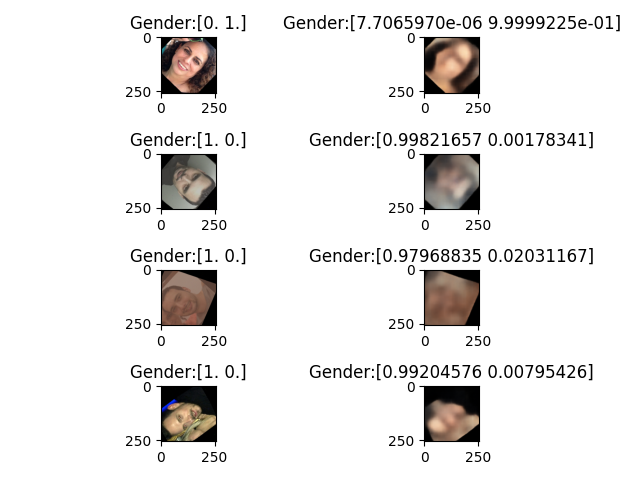

In [50]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [51]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [52]:
outTest = model(xTest)

In [53]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.92382920e+00, 1.25910807e+00, 1.03236663e+00],
          [1.15281248e+00, 7.42616951e-01, 1.24319446e+00],
          [1.16675019e+00, 7.60263205e-01, 1.12460279e+00],
          ...,
          [1.68254972e-01, 1.89404637e-01, 2.58804113e-01],
          [2.16535181e-01, 3.00016701e-01, 2.74618864e-01],
          [1.22741014e-01, 1.65306330e-01, 3.37224305e-01]],
 
         [[8.81218314e-01, 5.07797122e-01, 5.29174805e-01],
          [1.21001470e+00, 4.86244708e-01, 6.96099877e-01],
          [1.30559468e+00, 4.75088507e-01, 6.38570905e-01],
          ...,
          [2.10364312e-01, 1.67920589e-01, 3.02395374e-01],
          [1.33874416e-01, 1.78598017e-01, 3.15018296e-01],
          [9.61652398e-02, 1.42302364e-01, 3.89562696e-01]],
 
         [[8.45652223e-01, 3.67083102e-01, 4.04944271e-01],
          [1.13908768e+00, 5.83838701e-01, 4.37576920e-01],
          [1.42891335e+00, 6.04418397e-01, 6.76052094e-0

<IPython.core.display.Javascript object>


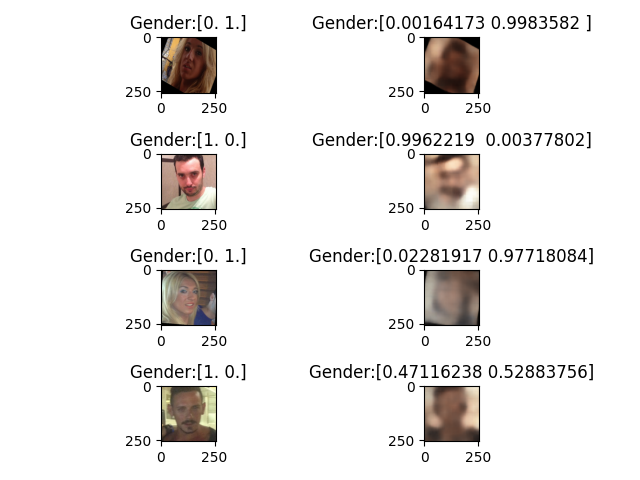

In [54]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()